Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting 2 folds for each of 10 candidates, totalling 20 fits


<ipython-input-3-af3ebeef7b0c>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[categorical_features] = x[categorical_features].astype('category')


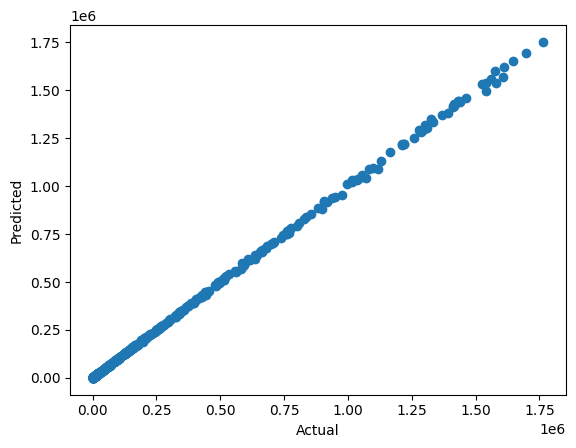

<ipython-input-3-af3ebeef7b0c>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[categorical_features] = x[categorical_features].astype('category')


Mean absolute error: 2500.931432511307
Mean squared error: 28917711.16544283
R2 score: 0.9998163099453004
Standard Deviation: 404439.496367274


KeyboardInterrupt: Interrupted by user

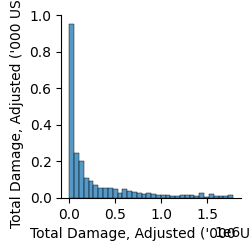

In [3]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
try:
  data = pd.read_csv('/content/drive/MyDrive/Natural_disasters_dataset.csv', encoding='utf-8')
except UnicodeDecodeError:
  with open('/content/drive/MyDrive/Natural_disasters_dataset.csv', encoding='utf-8' , errors='ignore') as f:
    data = pd.read_csv(f)


data.isnull().sum()
data = data.dropna(axis=0, subset=["Total Damage, Adjusted ('000 US$)"])


Q1 = data["Total Damage, Adjusted ('000 US$)"].quantile(0.25)
Q3 = data["Total Damage, Adjusted ('000 US$)"].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Show outliers (values outside the bounds)
outliers = data[(data["Total Damage, Adjusted ('000 US$)"] < lower_bound) | (data["Total Damage, Adjusted ('000 US$)"] > upper_bound)]
#print("Outliers:", outliers)

# Remove outliers
data_cleaned = data[(data["Total Damage, Adjusted ('000 US$)"] >= lower_bound) & (data["Total Damage, Adjusted ('000 US$)"] <= upper_bound)]
#print(data_cleaned)

x = data_cleaned[['Start Year', 'Disaster Type' , 'Disaster Subtype' , "Total Damage ('000 US$)" , "CPI"]]
y = data_cleaned["Total Damage, Adjusted ('000 US$)"]


categorical_features = ['Disaster Type', 'Disaster Subtype']
x[categorical_features] = x[categorical_features].astype('category')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=1000,          # Number of boosting rounds
    learning_rate=0.03,       # Smaller learning rate for smoother learning
    depth=10,                 # Depth of trees
    random_state=42,          # Reproducibility
    verbose=100               # Print progress every 100 iterations
)

param_dist = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [6, 8, 10],       # Controls tree depth
    'l2_leaf_reg': [1, 3, 5],  # L2 regularization
    'bagging_temperature': [0.5, 1, 2],  # Controls randomness
    'subsample': [0.8, 1.0]    # Row sampling
}
random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_distributions=param_dist,
    n_iter=10,  # Reduce iterations
    scoring='r2',
    cv=2,       # Reduce cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train, cat_features=categorical_features)

# Get the best model
best_catboost = random_search.best_estimator_

# Make predictions
y_pred = best_catboost.predict(x_test)


# Graphs to be able to visualize difference between predicted and actual data
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
sns.pairplot(data_cleaned[['Disaster Type', 'Disaster Subtype', 'Total Damage, Adjusted (\'000 US$)']])


# Statistical analysis
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
std_dev = np.std(data_cleaned['Total Damage, Adjusted (\'000 US$)'])


print("Mean absolute error:" , mae)
print("Mean squared error:" , mse)
print("R2 score:" , r2)
print('Standard Deviation:' , std_dev)





# Define preprocessing for categorical and numerical features
numerical_features = ['Start Year', "Total Damage ('000 US$)" , "CPI"]

# Convert categorical features to category type
categorical_features = ['Disaster Type', 'Disaster Subtype']
x[categorical_features] = x[categorical_features].astype('category')

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features), #handle_unknown='ignore' added
        ('num', 'passthrough', numerical_features)
    ])
preprocessor.fit(x)
ED = preprocessor.transform(x)

# Train the model
ED_train, ED_test, y_train, y_test = train_test_split(ED, y, train_size=0.8, random_state=42)

while True:
    try:
        sy = int(input('Enter the start year:'))
        if sy >= 2024:
            raise ValueError("Start year must be before 2024.")

        dt = input("Enter the disaster type:")
        dst = input("Enter the disaster subtype:")
        td = float(input("Enter the total damage (in USD):"))
        break
    except ValueError as e:
        print(f"Invalid input: {e}")

# Create a DataFrame for user input
user_input = pd.DataFrame({
    'Start Year': [sy],
    'Disaster Type': [dt],
    'Disaster Subtype': [dst],
    "Total Damage ('000 US$)": [td],
    "CPI": [0]  # Assign a default CPI value if unknown
})

# Convert categorical features to category type
user_input['Disaster Type'] = user_input['Disaster Type'].astype('category')
user_input['Disaster Subtype'] = user_input['Disaster Subtype'].astype('category')

# Predict using the trained CatBoost model
Prediction = best_catboost.predict(user_input)
print('Predicted adjusted damage in USD:', Prediction)



#mse = mean_squared_error(y_test, Prediction)
#mae = mean_absolute_error(y_test, Prediction)
#r2 = r2_score(y_test, Prediction)

#print("Mean Saquared Error:" , mse)
#print("Mean Absolute Error" , mae)
#print("R2 Score:" , r2)
